# Libraries

In [ ]:
! pip install tqdm boto3 requests regex sentencepiece sacremoses
# Packages must be loaded in this order or "torch.hub.load" does not work.
# Probably there is a version conflict!?
! pip install accelerate -U
! pip install transformers[torch] huggingface_hub datasets
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 116.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from datasets import Dataset, DatasetDict

import torch
# from torch.utils.data import Dataset, DataLoader
from torch.utils import data # data.Dataset, data.DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

from evaluate import load

from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device.type} device")

Using cuda device


# Download the data

In [ ]:
! pip install -q kaggle

In [ ]:
# Upload the "kaggle.json" file
files.upload()

In [ ]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# remove the file from wd
! rm kaggle.json

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Check of the file is in the folder
!ls -a ~/.kaggle/
# ! ls ../content

.  ..  kaggle.json


In [ ]:
# Download Data: !kaggle competitions download -c "name-of-competition"
! kaggle competitions download -c "nlp-getting-started"

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 99.0MB/s]


In [ ]:
# Create a directory named train,
! mkdir data

# unzip train data there,
! unzip nlp-getting-started.zip -d data
! rm nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


# Pretrained model

In [ ]:
pretrained_model_id = "bert-base-uncased"

# Data

## Import data

In [ ]:
df_train_val = pd.read_csv("./data/train.csv")
# Convert "NaN" to "Unknown"
df_train_val["keyword"].fillna("Unknown", inplace=True)
df_train_val.head()

,id,keyword,location,text,target
0,1,Unknown,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,Unknown,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,Unknown,NaN,All residents asked to 'shelter in place' are ...,1
3,6,Unknown,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,Unknown,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Vocabulary

For "keyword" model

In [ ]:
def yield_tokens(data):
    for k in data["keyword"]:
        yield [k]

vocab = build_vocab_from_iterator(yield_tokens(df_train_val), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

## Split train val

In [ ]:
def prepare_data(df):
  df_train, df_val = train_test_split(
      df,
      test_size=0.2,
      random_state=42,
      shuffle=True)

  df_train.reset_index(drop=True, inplace=True)
  df_val.reset_index(drop=True, inplace=True)

  train_texts = df_train["text"].copy()
  train_labels = df_train["target"].copy()
  train_keywords = df_train["keyword"].copy()
  val_texts = df_val["text"].copy()
  val_labels = df_val["target"].copy()
  val_keywords = df_val["keyword"].copy()

  train_dataset = Dataset.from_dict({
      "text": train_texts,
      "keyword": train_keywords,
      "label": train_labels
  })

  val_dataset = Dataset.from_dict({
      "text": val_texts,
      "keyword": val_keywords,
      "label": val_labels
  })

  raw_datasets = DatasetDict({
      "train": train_dataset,
      "val": val_dataset
  })

  return raw_datasets

In [ ]:
raw_datasets = prepare_data(df_train_val)

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'keyword', 'label'],
        num_rows: 6090
    })
    val: Dataset({
        features: ['text', 'keyword', 'label'],
        num_rows: 1523
    })
})

## Tokenizer for "text"

In [ ]:
tokenizer_text = AutoTokenizer.from_pretrained(pretrained_model_id)

def tokenize_function(example):
  return tokenizer_text(example["text"], truncation=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'keyword', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    val: Dataset({
        features: ['text', 'keyword', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})

In [ ]:
print(f"text: {tokenized_datasets['train']['text'][0]}")
print(f"keyword: {tokenized_datasets['train']['keyword'][0]}")
print(f"label: {tokenized_datasets['train']['label'][0]}")
print(f"input_ids: {tokenized_datasets['train']['input_ids'][0]}")
print(f"token_type_ids: {tokenized_datasets['train']['token_type_ids'][0]}")
print(f"attention_mask: {tokenized_datasets['train']['attention_mask'][0]}")

text: Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR
keyword: military
label: 1
input_ids: [101, 26103, 1998, 7481, 4106, 1997, 2342, 2000, 2224, 9593, 5968, 1999, 3386, 1012, 1001, 20168, 19841, 2887, 2510, 4188, 7806, 1012, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1058, 14227, 3723, 25856, 2102, 16523, 102]
token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Tokenizer for "keyword"

In [ ]:
tokenizer_keyword = get_tokenizer("basic_english")
keyword_pipeline = lambda x: vocab(tokenizer_keyword(x))

## Dataset class

In [ ]:
class TweetDisDataset(Dataset):

    def __init__(self, tokenized_datasets):
      self.keyword = tokenized_datasets["keyword"]
      self.text = tokenized_datasets["text"]
      self.label = tokenized_datasets["label"]
      self.input_ids = tokenized_datasets["input_ids"]
      self.token_type_ids = tokenized_datasets["token_type_ids"]
      self.attention_mask = tokenized_datasets["attention_mask"]


    def __len__(self):
      return len(self.label)

    def __getitem__(self, idx):
      keyword_list = [self.keyword[i] for i in idx]
      tokenized_keywords = [keyword_pipeline(token)[0] for token in keyword_list]
      texts = [self.text[i] for i in idx]
      label = [self.label[i] for i in idx]
      input_ids = [self.input_ids[i] for i in idx]
      token_type_ids = [self.token_type_ids[i] for i in idx]
      attention_mask = [self.attention_mask[i] for i in idx]

      sample = {
          "keyword": tokenized_keywords,
          "text": texts,
          "label": label,
          "input_ids": input_ids,
          "token_type_ids": token_type_ids,
          "attention_mask": attention_mask,
      }

      return sample


def collate_fn(data):
    keyword = [data[i]["keyword"] for i in range(len(data))]
    keyword = torch.tensor(keyword)

    text = [data[i]["text"] for i in range(len(data))]

    label = [data[i]["label"] for i in range(len(data))]
    label = torch.tensor(label)

    input_ids = [data[i]["input_ids"] for i in range(len(data))]
    input_ids = [torch.tensor(id) for id in input_ids]
    input_ids = pad_sequence(input_ids, batch_first=True)

    token_type_ids = [data[i]["token_type_ids"] for i in range(len(data))]
    token_type_ids = [torch.tensor(tti) for tti in token_type_ids]
    token_type_ids = pad_sequence(token_type_ids, batch_first=True)

    attention_mask = [data[i]["attention_mask"] for i in range(len(data))]
    attention_mask = [torch.tensor(am) for am in attention_mask]
    attention_mask = pad_sequence(attention_mask, batch_first=True)

    sample = {
        "keyword":keyword,
        "tex":text,
        "label":label,
        "input_ids":input_ids,
        "token_type_ids":token_type_ids,
        "attention_mask":attention_mask
    }
    return sample

In [ ]:
train_dataset_TMP = TweetDisDataset(tokenized_datasets["train"])
dataloader_TMP = data.DataLoader(
    train_dataset_TMP,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn)

next(iter(dataloader_TMP))

{'keyword': tensor([152, 185]),
 'tex': ['THE CHEMICAL BROTHERS to play The Armory in SF tomorrow night!: EMERGENCY BAY AREA EDM ANNOUNCEMENT \x89ÛÒ THE CHEM... http://t.co/3LN8TrHw6X',
  'Parental experience may help coral offspring survive climate change: Preconditioning adult corals to increased... http://t.co/N9c3i9v8gO'],
 'label': tensor([0, 0]),
 'input_ids': tensor([[  101,  1996,  5072,  3428,  2000,  2377,  1996, 24139,  1999, 16420,
           4826,  2305,   999,  1024,  5057,  3016,  2181,  3968,  2213,  8874,
           1057,  2080,  1996, 18178,  2213,  1012,  1012,  1012,  8299,  1024,
           1013,  1013,  1056,  1012,  2522,  1013,  1017, 19666,  2620, 16344,
           2232,  2860,  2575,  2595,   102],
         [  101, 18643,  3325,  2089,  2393, 11034, 13195,  5788,  4785,  2689,
           1024,  3653,  8663, 20562,  2075,  4639, 11034,  2015,  2000,  3445,
           1012,  1012,  1012,  8299,  1024,  1013,  1013,  1056,  1012,  2522,
           1013,  1050,  2

# Model for "keyword"

## Model & funcs

In [ ]:
class EmbDenseModel(torch.nn.Module):

  def __init__(self, vocab_size, embedding_dim, n_units_1, n_units_2):
    super().__init__()
    torch.manual_seed(54321)
    lin1_units = n_units_1
    lin2_units = n_units_2
    # vocab_size: size of the dictionary of embeddings
    # embedding_dim: size of embedding vector
    self.emb_layer = torch.nn.Embedding(vocab_size, embedding_dim)
    self.lin1 = torch.nn.Linear(embedding_dim, lin1_units)
    self.lin2 = torch.nn.Linear(lin1_units, lin2_units)
    self.lin3 = torch.nn.Linear(lin2_units, 1)
    #
    self.relu1 = torch.nn.ReLU()
    self.relu2 = torch.nn.ReLU()

  def forward(self, x):
    x = self.emb_layer(x)
    x = self.lin1(x)
    x = self.relu1(x) # x = torch.nn.functional.relu(x)
    x = self.lin2(x)
    x = self.relu2(x) # x = torch.nn.functional.relu(x)
    x = self.lin3(x)
    x = torch.nn.functional.sigmoid(x)
    return x

In [ ]:
def build_dataset(batch_size, datasets):
  train_dataset = TweetDisDataset(datasets["train"])
  train_dataloader = data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      collate_fn=collate_fn)

  val_dataset = TweetDisDataset(datasets["val"])
  val_dataloader = data.DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=True,
      collate_fn=collate_fn)

  return train_dataloader, val_dataloader

In [ ]:
def train_epoch(model, loader, optimizer, loss_fn):
  model.train() # Training phase
  running_loss = 0.0

  running_acc = 0
  for data in loader:

    # Get data
    keywords = data["keyword"]
    labels = data["label"]

    # Move inputs and labels to the device
    keywords = keywords.to(device)
    labels = labels.to(device)

    # Clear the gradients (because gradients are accumulated)
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(keywords)
    labels = labels.unsqueeze(1)
    labels = labels.float()

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    optimizer.zero_grad()
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather loss
    running_loss += loss.item()

    # Gather accuracy
    equals = torch.Tensor.round(outputs) == labels
    equals = equals.to(torch.float)
    equals = torch.sum(equals)
    running_acc += equals

  # Store loss
  train_loss = running_loss / len(loader.dataset)

  # Store accuracy
  train_acc = running_acc / len(loader.dataset)

  return train_loss, train_acc


In [ ]:
def val_epoch(model, loader, loss_fn):
  model.eval() # Set the model to evaluation mode
  running_vloss = 0.0

  # Disable gradient computation and reduce memory consumption
  with torch.no_grad():
    running_acc = 0
    for vdata in loader:

      # Get data
      keywords = vdata["keyword"]
      labels = vdata["label"]

      # Move inputs and labels to the device
      keywords = keywords.to(device)
      labels = labels.to(device)

      # Make predictions for this batch
      outputs = model(keywords)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      # Compute the loss and its gradients
      loss = loss_fn(outputs, labels)

      # Gather loss and accuracy
      running_vloss += loss.item()

      # Gather accuracy
      equals = torch.Tensor.round(outputs) == labels
      equals = equals.to(torch.float)
      equals = torch.sum(equals)
      running_acc += equals

  # Store loss
  val_loss = running_vloss / len(loader.dataset)

  # Store accuracy
  val_acc = running_acc / len(loader.dataset)

  return val_loss, val_acc

## Training

In [ ]:
# len(vocab.get_itos())
VOCAB_SIZE = vocab.__len__() # 223
BATCH_SIZE = 128
EMB_DIM = 128
EPOCHS = 2
N_UNITS_1 = 64
N_UNITS_2 = 32

train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []

# Create data loaders
train_dataloader, val_dataloader = build_dataset(BATCH_SIZE, tokenized_datasets)

# Create model keyword
model_kw = EmbDenseModel(VOCAB_SIZE, EMB_DIM, N_UNITS_1, N_UNITS_2)
model_kw.to(device)

# Loss function: Binary Cross Entropy
loss_fn = torch.nn.BCELoss()
# Optimizer
optimizer = torch.optim.Adam(model_kw.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
  # Training phase
  train_loss, train_acc = train_epoch(model_kw, train_dataloader, optimizer, loss_fn)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc.cpu().numpy())
  # Validation phase
  val_loss, val_acc = val_epoch(model_kw, val_dataloader, loss_fn)
  val_losses.append(val_loss)
  val_accuracy.append(val_acc.cpu().numpy())
  # Print log
  log_1 = f"Epoch {epoch+1}/{EPOCHS}"
  log_2 = f" - Train: loss = {train_loss:.5f};  acc = {train_acc:.3f}"
  log_3 = f" - Val: loss = {val_loss:.5f};  acc = {val_acc:.3f}"
  print(log_1 + log_2 + log_3)

Epoch 1/2 - Train: loss = 0.00520;  acc = 0.601 - Val: loss = 0.00497;  acc = 0.667
Epoch 2/2 - Train: loss = 0.00452;  acc = 0.724 - Val: loss = 0.00461;  acc = 0.720


## Loss & accuracy

In [ ]:
def render_history(train_losses, val_losses, train_acc, val_acc):
  plt.figure(figsize=(10, 3))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Training loss")
  plt.plot(val_losses, label="Validation loss")
  plt.ylabel("Loss")
  plt.legend(frameon=False)
  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label="Training Accuracy")
  plt.plot(val_acc, label="Validation Accuracy")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

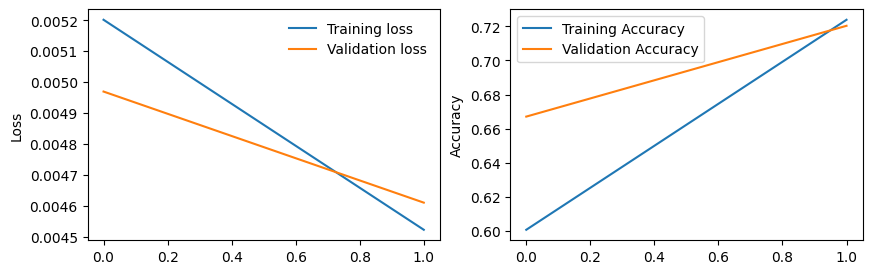

In [ ]:
render_history(train_losses, val_losses, train_accuracy, val_accuracy)

## Predictions

In [ ]:
def calc_acc(df):

  model_kw.eval()

  X = [keyword_pipeline(k) for k in df["keyword"]]
  X = torch.tensor(X)
  X = X.to(device)
  X = X.squeeze()

  y_pred = model_kw(X.squeeze())
  y_pred = y_pred.squeeze().numpy(force=True)
  y_pred = np.round(y_pred)

  y = [t for t in df["target"]]

  acc = y_pred == y
  f1 = f1_score(y, y_pred)

  print(f"accuracy: {acc.mean().round(3)}\nf1: {f1.round(3)}")

  return y_pred

In [ ]:
y_pred_keyword = calc_acc(df_train_val)

accuracy: 0.743
f1: 0.7


# Model for "text"

## Tokenizer & model

In [ ]:
BATH_SIZE = 64
EPOCHS = 1

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_text)

model_text = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_id,
    num_labels=2
)

# set training arguments
training_args = TrainingArguments(
    output_dir="./results", # output directory
    run_name=pretrained_model_id, # name of the W&B run
    num_train_epochs=EPOCHS, # number of training epochs
    per_device_train_batch_size=BATH_SIZE, # batch size per device during training
    per_device_eval_batch_size=16, # batch size for evaluation (if too high it runs out of memory)
    save_strategy="epoch", # save is done at the end of each epoch
    evaluation_strategy="epoch", # evaluation is done at the end of each epoch
    logging_strategy="epoch", # logging is done at the end of each epoch
    load_best_model_at_end=True,
    fp16=True, # Whether to use fp16 16-bit (mixed) precision training instead of 32-bit training
)

# Metrics function
def compute_metrics_fn(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)

  accuracy_metric = load("accuracy")
  f1_metric = load("f1")

  metrics = dict()
  metrics.update(accuracy_metric.compute(predictions=predictions, references=labels))
  metrics.update(f1_metric.compute(predictions=predictions, references=labels, average="macro")) # for macro F1

  return metrics

# define training loop
trainer = Trainer(
    model=model_text, # the instantiated Transformers model to be trained
    args=training_args, # training arguments
    train_dataset=tokenized_datasets["train"], # training dataset
    eval_dataset=tokenized_datasets["val"], # evaluation dataset
    data_collator=data_collator,
    compute_metrics=compute_metrics_fn,
)

# start training loop
trainer.train()

# Clear memory
torch.cuda.empty_cache()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.452100,0.389653,0.839790,0.833976


In [ ]:
trainer.evaluate()

{'eval_loss': 0.38965341448783875,
 'eval_accuracy': 0.8397898883782009,
 'eval_f1': 0.8339760818905744,
 'eval_runtime': 3.6388,
 'eval_samples_per_second': 418.547,
 'eval_steps_per_second': 26.382,
 'epoch': 1.0}

## Predictions

In [ ]:
# y_pred_text_train = trainer.predict(tokenized_datasets["train"])
# y_pred_text_val = trainer.predict(tokenized_datasets["val"])
#
# print(len(y_pred_text_train))
# print(len(y_pred_text_val))
#
# print(y_pred_text_val.predictions)

In [ ]:
def classify_text(text):
  inputs = tokenizer_text(text, truncation=True, padding=True, return_tensors="pt").to("cuda")
  outputs = model_text(**inputs)
  probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
  predicted_class = torch.argmax(probabilities).item()
  return predicted_class

In [ ]:
y_pred_text = df_train_val["text"].map(classify_text)

# Compare predictions

In [ ]:
print(len(y_pred_keyword)) # "keyword" model
print(len(y_pred_text)) # "text" model
print(len(df_train_val["target"])) # "target" length

7613
7613
7613


In [ ]:
y_pred_keyword_correct = df_train_val["target"] == y_pred_keyword
y_pred_text_correct = df_train_val["target"] == y_pred_text

print(np.mean(y_pred_keyword_correct))
print(np.mean(y_pred_text_correct))

0.743202416918429
0.8690398003415211


In [ ]:
np.mean(y_pred_keyword_correct == y_pred_text_correct)

0.7793248390910285

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_pred_keyword_correct, y_pred_text_correct)
cm

array([[ 636, 1319],
       [ 361, 5297]])

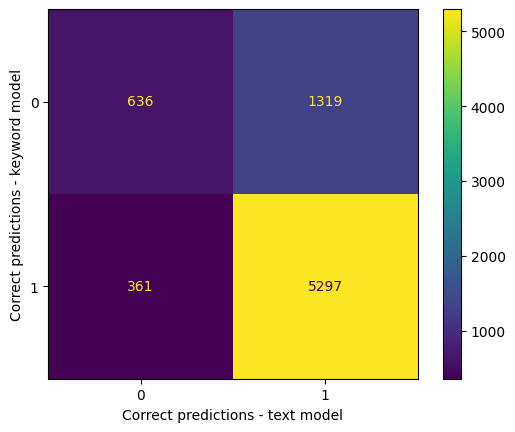

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.ylabel('Correct predictions - keyword model')
plt.xlabel('Correct predictions - text model')
plt.show()

# Model for "keyword" and "text"

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model_text.parameters():
    param.requires_grad = False

In [ ]:
# for name, param in model_kw.named_parameters():
#   print(f"{name} -- {param.requires_grad}")

# Freeze parameters so we don't backprop through them
for param in model_kw.parameters():
    param.requires_grad = False

In [ ]:
class ModelTextKeyword(torch.nn.Module):

  def __init__(self, model_keyword, model_text):
    super().__init__()
    torch.manual_seed(54321)
    self.model_keyword = model_keyword
    self.model_text = model_text
    self.lin1 = torch.nn.Linear(3, 1)

  def forward(self, x1, x2, x3):
    c1 = self.model_keyword(x1)
    c2 = self.model_text(x2, x3)
    c2_logits = c2["logits"]
    c1_c2 = torch.cat((c1, c2_logits), dim=1)
    x = self.lin1(c1_c2)
    x = torch.nn.functional.sigmoid(x)

    return x

## Training

In [ ]:
def train_epoch_t_kw(model, loader, optimizer, loss_fn):
  model.train() # Training phase
  running_loss = 0.0

  running_acc = 0
  for data in loader:

    # Get data
    keywords = data["keyword"]
    input_ids = data["input_ids"]
    attention_masks = data["attention_mask"]
    labels = data["label"]

    # Move inputs and labels to the device
    keywords = keywords.to(device)
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    labels = labels.to(device)

    # Clear the gradients (because gradients are accumulated)
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs = model(keywords, input_ids, attention_masks)
    labels = labels.unsqueeze(1)
    labels = labels.float()

    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather loss
    running_loss += loss.item()

    # Gather accuracy
    equals = torch.Tensor.round(outputs) == labels
    equals = equals.to(torch.float)
    equals = torch.sum(equals)
    running_acc += equals

  # Store loss
  train_loss = running_loss / len(loader.dataset)

  # Store accuracy
  train_acc = running_acc / len(loader.dataset)

  return train_loss, train_acc


In [ ]:
def val_epoch_t_kw(model, loader, loss_fn):
  model.eval() # Set the model to evaluation mode
  running_loss = 0.0

  # Disable gradient computation and reduce memory consumption
  with torch.no_grad():
    running_acc = 0
    for vdata in loader:

      # Get data
      keywords = vdata["keyword"]
      input_ids = vdata["input_ids"]
      attention_masks = vdata["attention_mask"]
      labels = vdata["label"]

      # Move inputs and labels to the device
      keywords = keywords.to(device)
      input_ids = input_ids.to(device)
      attention_masks = attention_masks.to(device)
      labels = labels.to(device)

      # Make predictions for this batch
      outputs = model(keywords, input_ids, attention_masks)
      labels = labels.unsqueeze(1)
      labels = labels.float()

      # Compute the loss and its gradients
      loss = loss_fn(outputs, labels)

      # Gather loss
      running_loss += loss.item()

      # Gather accuracy
      equals = torch.Tensor.round(outputs) == labels
      equals = equals.to(torch.float)
      equals = torch.sum(equals)
      running_acc += equals

  # Store loss
  val_loss = running_loss / len(loader.dataset)

  # Store accuracy
  val_acc = running_acc / len(loader.dataset)

  return val_loss, val_acc


In [ ]:
# Simple training loop
EPOCHS = 15
BATCH_SIZE = 128
train_losses_1, val_losses_1 = [], []
train_accuracy_1, val_accuracy_1 = [], []

# Create data loaders
train_dataloader, val_dataloader = build_dataset(BATCH_SIZE, tokenized_datasets)

# Model
model_t_kw = ModelTextKeyword(model_kw, model_text).to(device)
model_t_kw.to(device)

# Loss function: Binary Cross Entropy
loss_fn = torch.nn.BCELoss()
# Optimizer
optimizer = torch.optim.Adam(model_t_kw.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
  # Training phase
  train_loss, train_acc = train_epoch_t_kw(model_t_kw, train_dataloader, optimizer, loss_fn)
  train_losses_1.append(train_loss)
  train_accuracy_1.append(train_acc.cpu().numpy())

  # Validation phase
  val_loss, val_acc   = val_epoch_t_kw(model_t_kw, val_dataloader, loss_fn)
  val_losses_1.append(val_loss)
  val_accuracy_1.append(val_acc.cpu().numpy())

  # Print log
  log_1 = f"Epoch {epoch+1}/{EPOCHS}"
  log_2 = f" - Train: loss = {train_loss:.5f};  acc = {train_acc:.3f}"
  log_3 = f" - Val: loss = {val_loss:.5f};  acc = {val_acc:.4f}"
  print(log_1 + log_2 + log_3)


Epoch 1/15 - Train: loss = 0.00502;  acc = 0.445 - Val: loss = 0.00492;  acc = 0.4708
Epoch 2/15 - Train: loss = 0.00472;  acc = 0.660 - Val: loss = 0.00465;  acc = 0.7295
Epoch 3/15 - Train: loss = 0.00445;  acc = 0.826 - Val: loss = 0.00442;  acc = 0.7938
Epoch 4/15 - Train: loss = 0.00422;  acc = 0.856 - Val: loss = 0.00422;  acc = 0.8168
Epoch 5/15 - Train: loss = 0.00404;  acc = 0.862 - Val: loss = 0.00405;  acc = 0.8313
Epoch 6/15 - Train: loss = 0.00385;  acc = 0.865 - Val: loss = 0.00390;  acc = 0.8339
Epoch 7/15 - Train: loss = 0.00370;  acc = 0.865 - Val: loss = 0.00378;  acc = 0.8365
Epoch 8/15 - Train: loss = 0.00356;  acc = 0.871 - Val: loss = 0.00367;  acc = 0.8391
Epoch 9/15 - Train: loss = 0.00346;  acc = 0.867 - Val: loss = 0.00358;  acc = 0.8398
Epoch 10/15 - Train: loss = 0.00336;  acc = 0.869 - Val: loss = 0.00350;  acc = 0.8418
Epoch 11/15 - Train: loss = 0.00326;  acc = 0.870 - Val: loss = 0.00343;  acc = 0.8424
Epoch 12/15 - Train: loss = 0.00318;  acc = 0.871 - 

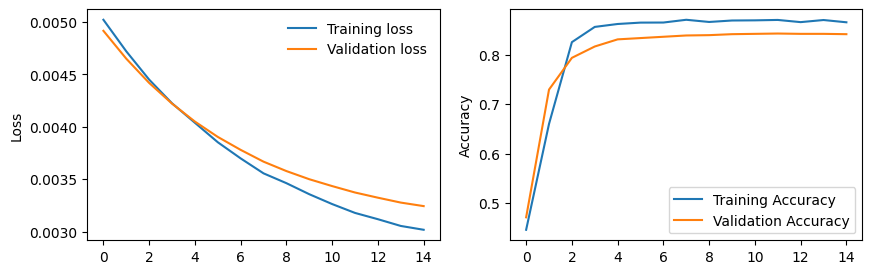

In [ ]:
render_history(train_losses_1, val_losses_1, train_accuracy_1, val_accuracy_1)

In [ ]:
# for name, param in model_t_kw.named_parameters():
#   print(f"{name} -- {param.requires_grad}")

## Retrain the model (12 epochs)

In [ ]:
# Simple training loop
EPOCHS = 12
BATCH_SIZE = 128
train_losses_2, val_losses_2 = [], []
train_accuracy_2, val_accuracy_2 = [], []

# Create data loaders
train_dataloader, val_dataloader = build_dataset(BATCH_SIZE, tokenized_datasets)

# Model
model_t_kw_2 = ModelTextKeyword(model_kw, model_text).to(device)
model_t_kw_2.to(device)

# Loss function: Binary Cross Entropy
loss_fn = torch.nn.BCELoss()
# Optimizer
optimizer = torch.optim.Adam(model_t_kw_2.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
  # Training phase
  train_loss, train_acc = train_epoch_t_kw(model_t_kw_2, train_dataloader, optimizer, loss_fn)
  train_losses_2.append(train_loss)
  train_accuracy_2.append(train_acc.cpu().numpy())

  # Validation phase
  val_loss, val_acc   = val_epoch_t_kw(model_t_kw_2, val_dataloader, loss_fn)
  val_losses_2.append(val_loss)
  val_accuracy_2.append(val_acc.cpu().numpy())

  # Print log
  log_1 = f"Epoch {epoch+1}/{EPOCHS}"
  log_2 = f" - Train: loss = {train_loss:.5f};  acc = {train_acc:.3f}"
  log_3 = f" - Val: loss = {val_loss:.5f};  acc = {val_acc:.4f}"
  print(log_1 + log_2 + log_3)


Epoch 1/12 - Train: loss = 0.00502;  acc = 0.445 - Val: loss = 0.00492;  acc = 0.4708
Epoch 2/12 - Train: loss = 0.00472;  acc = 0.660 - Val: loss = 0.00465;  acc = 0.7295
Epoch 3/12 - Train: loss = 0.00445;  acc = 0.826 - Val: loss = 0.00442;  acc = 0.7938
Epoch 4/12 - Train: loss = 0.00422;  acc = 0.856 - Val: loss = 0.00422;  acc = 0.8168
Epoch 5/12 - Train: loss = 0.00404;  acc = 0.862 - Val: loss = 0.00405;  acc = 0.8313
Epoch 6/12 - Train: loss = 0.00385;  acc = 0.865 - Val: loss = 0.00390;  acc = 0.8339
Epoch 7/12 - Train: loss = 0.00370;  acc = 0.865 - Val: loss = 0.00378;  acc = 0.8365
Epoch 8/12 - Train: loss = 0.00356;  acc = 0.871 - Val: loss = 0.00367;  acc = 0.8391
Epoch 9/12 - Train: loss = 0.00346;  acc = 0.867 - Val: loss = 0.00358;  acc = 0.8398
Epoch 10/12 - Train: loss = 0.00336;  acc = 0.869 - Val: loss = 0.00350;  acc = 0.8418
Epoch 11/12 - Train: loss = 0.00326;  acc = 0.870 - Val: loss = 0.00343;  acc = 0.8424
Epoch 12/12 - Train: loss = 0.00318;  acc = 0.871 - 

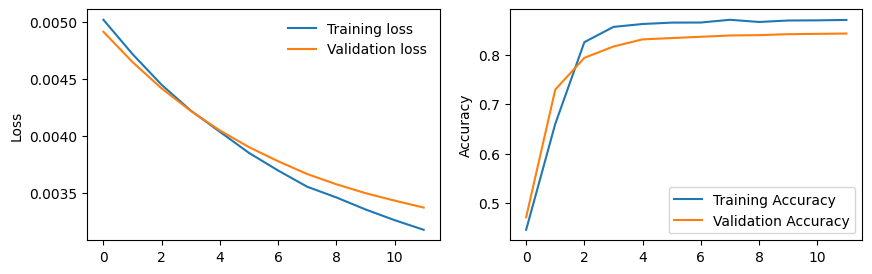

In [ ]:
render_history(train_losses_2, val_losses_2, train_accuracy_2, val_accuracy_2)

In [ ]:
# for name, param in model_t_kw_2.named_parameters():
#   print(f"{name} -- {param.requires_grad}")

# Test set

For Kaggle submission

In [ ]:
df_test = pd.read_csv("./data/test.csv")
df_test["keyword"].fillna("Unknown", inplace=True)

df_test.head()

,id,keyword,location,text
0,0,Unknown,NaN,Just happened a terrible car crash
1,2,Unknown,NaN,"Heard about #earthquake is different cities, s..."
2,3,Unknown,NaN,"there is a forest fire at spot pond, geese are..."
3,9,Unknown,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,Unknown,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
test_texts = df_test["text"].copy()
test_keywords = df_test["keyword"].copy()

test_dataset = Dataset.from_dict({
    "text": test_texts,
    "keyword": test_keywords
})

test_dataset

Dataset({
    features: ['text', 'keyword'],
    num_rows: 3263
})

In [ ]:
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'keyword', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [ ]:
class TweetDisDatasetTest(Dataset):

    def __init__(self, tokenized_datasets):
      self.keyword = tokenized_datasets["keyword"]
      self.text = tokenized_datasets["text"]
      self.input_ids = tokenized_datasets["input_ids"]
      self.token_type_ids = tokenized_datasets["token_type_ids"]
      self.attention_mask = tokenized_datasets["attention_mask"]


    def __len__(self):
      return len(self.keyword)

    def __getitem__(self, idx):
      keyword_list = [self.keyword[i] for i in idx]
      tokenized_keywords = [keyword_pipeline(token)[0] for token in keyword_list]
      texts = [self.text[i] for i in idx]
      input_ids = [self.input_ids[i] for i in idx]
      token_type_ids = [self.token_type_ids[i] for i in idx]
      attention_mask = [self.attention_mask[i] for i in idx]

      sample = {
          "keyword": tokenized_keywords,
          "text": texts,
          "input_ids": input_ids,
          "token_type_ids": token_type_ids,
          "attention_mask": attention_mask,
      }

      return sample


def collate_fn_test(data):
    keyword = [data[i]["keyword"] for i in range(len(data))]
    keyword = torch.tensor(keyword)

    text = [data[i]["text"] for i in range(len(data))]

    input_ids = [data[i]["input_ids"] for i in range(len(data))]
    input_ids = [torch.tensor(id) for id in input_ids]
    input_ids = pad_sequence(input_ids, batch_first=True)

    token_type_ids = [data[i]["token_type_ids"] for i in range(len(data))]
    token_type_ids = [torch.tensor(tti) for tti in token_type_ids]
    token_type_ids = pad_sequence(token_type_ids, batch_first=True)

    attention_mask = [data[i]["attention_mask"] for i in range(len(data))]
    attention_mask = [torch.tensor(am) for am in attention_mask]
    attention_mask = pad_sequence(attention_mask, batch_first=True)

    sample = {
        "keyword":keyword,
        "tex":text,
        "input_ids":input_ids,
        "token_type_ids":token_type_ids,
        "attention_mask":attention_mask
    }
    return sample

In [ ]:
test_dataset = TweetDisDatasetTest(tokenized_test_dataset)
test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn_test)

In [ ]:
y_test_pred = []

for data_test in test_dataloader:

    # Get data
    keywords = data_test["keyword"]
    input_ids = data_test["input_ids"]
    attention_masks = data_test["attention_mask"]

    # Move inputs and labels to the device
    keywords = keywords.to(device)
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)

    # Make predictions for this batch
    output = model_t_kw_2(keywords, input_ids, attention_masks)
    y_test_pred += output.squeeze().tolist()

len(y_test_pred)

3263

In [ ]:
df_submission = pd.DataFrame({
    "id": df_test.id,
    "target": np.array(y_test_pred).round().astype(int)
})

df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
df_submission.to_csv("./data/test_submission.csv", index=False)